In [423]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# path = '/content/gdrive/MyDrive/Applied ML/'
path = './data/'
# save_path = 

In [424]:
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import files

# warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina'

np.random.seed(333)

# from copy import deepcopy
# import multiprocessing as mp
# from multiprocessing.pool import Pool, ThreadPool
# from functools import partial
# import time
# from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

import os
import pickle

# Class definition

In [425]:
class Mle:
  def __init__(self, data_path:str, sep:str=',', remove_head:bool=True,
              features_path:str='', fsep:str=',', rem_fhead:bool=True,
              rebuild:bool=False) -> None:
              
    self.data_path     = data_path;       self.sep  = sep;    self.remove_head = remove_head
    self.features_path = features_path;   self.fsep = fsep;   self.rem_fhead   = rem_fhead
    self.rebuild = rebuild

    self.users_id = {};                   self.items_id = {}

    self.users_rating       = [];         self.items_rating       = []
    self.users_rating_train = [];         self.items_rating_train = []
    self.users_rating_test  = [];         self.items_rating_test  = []

    self.user_ratings_count        = [];   self.item_ratings_count        = []
    self.user_ratings_count_train  = [];   self.item_ratings_count_train  = []
    self.user_ratings_count_test   = [];   self.item_ratings_count_test   = []

    self.user_ratings_cum        = [];     self.item_ratings_cum       = []
    self.user_ratings_cum_train  = [];     self.item_ratings_cum_train = []
    self.user_ratings_cum_test   = [];     self.item_ratings_cum_test  = []

    self.users_freq_rating =     [];      self.items_freq_rating     = []
    self.users_uniq_rating_nbr = [];      self.items_uniq_rating_nbr = []

    self.number_of_users = self.number_of_items = 0

    self.mle_train = None; self.rmse_train = None;  self.rmse_test = None

    self.dim = 2

    self.data_loader()
    self.get_freq()
    self.plots_path_builder()


# MAIN METHODS
  def get_data(self) -> None:
    with open(self.data_path, 'r') as data_file:
      data = data_file.readlines()
      uid = {};       mid = {}
      urat = [];      mrat = []
      ucount = [];    mcount = []

      a = b = 0
      i = j = 0
      rm = False
      k = 0
      for d in tqdm(data, desc="Data indexing"):
        if self.remove_head and not(rm):
          rm = not(rm)
          continue
        u = d.strip().split(self.sep)
        if u[0] not in uid:
          uid[u[0]] = a
          ucount += [0]
          a += 1
        i = sum(ucount[0:uid[u[0]]+1])
        ucount[uid[u[0]]] += 1

        if u[1] not in mid:
          mid[u[1]] = b
          mcount += [0]
          b += 1
        j = sum(mcount[0:mid[u[1]]+1])
        mcount[mid[u[1]]] += 1
        
        urat.insert(i, (mid[u[1]], float(u[2])))
        mrat.insert(j, (uid[u[0]], float(u[2])))

      nbr_user, nbr_item = len(ucount), len(mcount)
      ucumcount = np.cumsum(ucount); mcumcount = np.cumsum(mcount)

    # if self.features_path:
    with open(self.features_path, 'r') as file:
      data = file.readlines()
      fid = {};     fitm = [];      mfea = []
      fmcount = [];   mfcount = list(np.zeros((nbr_item,), dtype='int'))
      a = b = 0
      i = j = 0
      rm = False
      k = 0
      for d in tqdm(data, desc="Feature indexing"):
        if self.rem_fhead and not(rm):
          rm = not(rm)
          continue
        mf = d.strip().split(self.fsep)
        features = mf[2].strip().split('|')
        if mf[0] not in mid:
          continue
        j = sum(mfcount[0:mid[mf[0]]+1])
        mfcount[mid[mf[0]]] = len(features)
        for f in features:
          if f not in fid:
            fid[f] = a
            fmcount += [0]
            a += 1
          i = sum(fmcount[0:fid[f]+1])
          fmcount[fid[f]] += 1

          fitm.insert(i, (mid[mf[0]]))
          mfea.insert(j, (fid[f]))
          j += 1

      self.users_id = uid;                self.items_id = mid
      self.users_rating = urat;           self.items_rating = mrat
      self.number_of_users = nbr_user;    self.number_of_items = nbr_item
      self.user_ratings_count = np.array(ucount);    self.item_ratings_count = np.array(mcount)
      self.user_ratings_cum = np.array(ucumcount);   self.item_ratings_cum = np.array(mcumcount)

      self.features_id = fid;             self.number_of_features = len(fmcount)
      self.feature_items = fitm;          self.item_features = mfea
      self.feature_items_count = np.array(fmcount);    self.item_features_count = np.array(mfcount)
      self.feature_items_cum = np.cumsum(fmcount);     self.item_features_cum = np.cumsum(mfcount)


  def split_data(self, ratio=0.1):
    nbr_user = self.number_of_users; nbr_item = self.number_of_items
    mrtr = []; irtr = {}; items_rating_train = []
    mrts = []; irts = {}; items_rating_test  = []

    for m in tqdm(range(nbr_user), desc="Data spliting"):
      urat = self.get_user_items_and_ratings(m, self.users_rating, self.user_ratings_cum)
      ui = len(urat)
      uj = int(np.round(ui*ratio))
      uk = np.random.choice(ui, uj, replace=False)
      for i, (n,r) in enumerate(urat):
        if i in uk:
          mrts += [(n, r)]
          if n not in irts:
            irts[n] = [(m, r)]
          else:
            irts[n] += [(m, r)]
        else:
          mrtr += [(n, r)]
          if n not in irtr:
            irtr[n] = [(m, r)]
          else:
            irtr[n] += [(m, r)]
      self.user_ratings_count_train += [ui-uj];    self.user_ratings_count_test  += [uj]

    for n in range(nbr_item):
      if n in irtr:
        items_rating_train += irtr[n];    self.item_ratings_count_train += [len(irtr[n])]
      else:
        self.item_ratings_count_train += [0]

      if n in irts:
        items_rating_test  += irts[n];    self.item_ratings_count_test += [len(irts[n])]
      else:
        self.item_ratings_count_test += [0]

    self.users_rating_train = mrtr;   self.items_rating_train = items_rating_train
    self.users_rating_test  = mrts;   self.items_rating_test = items_rating_test
    self.user_ratings_cum_train = np.cumsum(self.user_ratings_count_train)
    self.item_ratings_cum_train = np.cumsum(self.item_ratings_count_train)
    self.user_ratings_cum_test = np.cumsum(self.user_ratings_count_test)
    self.item_ratings_cum_test = np.cumsum(self.item_ratings_count_test)


  def get_freq(self) -> None:
    u, m = np.array(self.user_ratings_count), np.array(self.item_ratings_count)
    ufreq = []; mfreq = []
    uuniq = []; muniq = []
    while True:
      if len(u) == 0 & len(m) == 0:
        break
      if len(u) > 0:
        ufreq += [len(u[u==u[0]])]
        uuniq += [u[0]]
        u = u[u!=u[0]]
      if len(m) > 0:
        mfreq += [len(m[m==m[0]])]
        muniq += [m[0]]
        m = m[m!=m[0]]

    self.users_freq_rating = ufreq;  self.items_freq_rating = mfreq
    self.users_uniq_rating_nbr = uuniq;  self.items_uniq_rating_nbr = muniq


  def mle_loss(self, lambd:float=0.05, gamma:float=0.2, tau:float=0.01,
               E:float=5, mu:float=0, dim:int=None, epochs=50,
               with_users_items:bool=False, with_features:bool=False) -> None:

    # Initialisation
    self.lambd = lambd;   self.gamma = gamma;   self.tau = tau
    self.E = E;   self.mu = mu; self.epochs = epochs
    if dim is None:
      dim = self.dim
    else:
      self.dim = dim
    std = np.sqrt(E / np.sqrt(dim));    self.std = std
    fstd = 1 / np.sqrt(dim)

    self.user_prediction    = np.random.normal(mu, std, size=(self.number_of_users, dim));
    self.item_prediction    = np.random.normal(mu, std, size=(self.number_of_items, dim));
    self.feature_prediction = np.random.normal(0, fstd, size=(self.number_of_features, dim));

    self.user_biases = np.zeros(self.number_of_users);
    self.item_biases = np.zeros(self.number_of_items)

    self.mle_train = np.zeros(epochs); self.rmse_train = np.zeros(epochs)
    self.rmse_test = np.zeros(epochs)

    # Loss calculation
    for epoch in tqdm(range(epochs), desc="Data Training"):
      # Biases update
      ## User
      self.update_user_biases()
      ## Item
      self.update_item_biases()

      # with ThreadPoolExecutor(max_workers=20) as pool:
      #   pool.submit(self.update_user_biases, list(range(nbr_user)))
      #   pool.submit(self.update_item_biases, list(range(nbr_item)))
      # usumb2 = np.dot(ubiases, ubiases)
      # msumb2 = np.dot(mbiases, mbiases)

      # Update
      if with_users_items:
      ## User
        self.update_users()
      ## Item
        self.update_items(with_features)
      ## Features
        if with_features:
          self.update_features()

      # Loss
      ## Train data
      self.update_train_errors(epoch, with_users_items, with_features)
      ## Test data
      self.update_test_errors(epoch)


# PLOT METHODS
  def plot_freq(self, save=False, fgsize=[6,6], ftsize=11, alpha=0.7,
                title = 'Power low', xlabel = 'count', ylabel = 'frequency',
                ulabel = 'user', mlabel = 'item',
                ucolor = '#0E88FF', mcolor = '#FF0000'):
    # Initialisation
    ux = self.users_uniq_rating_nbr
    mx = self.items_uniq_rating_nbr
    uy = self.users_freq_rating
    my = self.items_freq_rating

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xscale("log", base=10)
    ax.set_yscale("log", base=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    ax.scatter(ux, uy, alpha=alpha, color=ucolor, label=ulabel)
    ax.scatter(mx, my, alpha=alpha, color=mcolor, label=mlabel)

    # Legend
    ax.legend(fontsize=ftsize)
    ax.set_title(title, pad=10)
    self.save_plot(plt, f'{self.plot_path}/power-low', save=save)
    

  def plot_loss(self, error='mle', save=False, fgname='mle', fgsize=[6,6], ftsize=11, alpha=1,
                title = 'Lost function', xlabel = 'Iteration', ylabel = 'mle value',
                lcolor = '#0E88FF', ecolor = '#FF0000') -> None:
    # Initialisation
    if self.mle_train is None:
      self.mle_loss()
    y_train = self.mle_train if error == 'mle' else self.rmse_train
    y_test  = []  if error == 'mle' else self.rmse_test
    x = np.array(range(1,self.epochs+1))

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    ax.plot(x, y_train, alpha=alpha, color=lcolor, marker="+", label='Training set')
    if error == 'rmse':
      ax.plot(x, y_test, alpha=alpha, color=ecolor, marker="*", label='Testing set')

    # Legend
    ax.legend(fontsize=ftsize)
    ax.set_title(f"{title} for dim = {self.dim}", pad=10)
    self.save_plot(plt, f'{self.plot_path}/{fgname}-dim{self.dim}-epochs{self.epochs}', save=save)

  def item_embedding(self, save=False, fgname='item-embedding', fgsize=[8,8], ftsize=11, alpha=1,
                title = 'Items embedding', xlabel = 'second component', ylabel = 'first component',
                color = '#0E88FF') -> None:
    # Initialisation
    x = self.item_prediction[:,0];    y = self.item_prediction[:,1]

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    ax.scatter(x, y, alpha=alpha, color=color)

    # Legend
    ax.legend(fontsize=ftsize)
    ax.set_title(f"{title} for dim = {self.dim}", pad=10)
    self.save_plot(plt, f'{self.plot_path}/{fgname}-dim{self.dim}-epochs{self.epochs}', save=save)

  def feature_embedding(self, save=False, fgname='feature-embedding', fgsize=[8,8], ftsize=11, alpha=1,
                title = 'Features embedding', xlabel = 'second component', ylabel = 'first component',
                color = '#0E88FF') -> None:
    # Initialisation
    x = self.feature_prediction[:,0];    y = self.feature_prediction[:,1]

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    ax.scatter(x, y, alpha=alpha, color=color)
    for fid in self.features_id:
      ax.annotate(fid, (x[self.features_id[fid]], y[self.features_id[fid]]))
    # Legend
    ax.legend(fontsize=ftsize)
    ax.set_title(f"{title} for dim = {self.dim}", pad=10)
    self.save_plot(plt, f'{self.plot_path}/{fgname}-dim{self.dim}-epochs{self.epochs}', save=save)


# USEFUL METHODS
## SETTERS
  def update_user_biases(self):
    for m in range(self.number_of_users):
      b = 0
      ratings = self.get_user_items_and_ratings(m, self.users_rating_train, self.user_ratings_cum_train)
      for n, r in ratings:
        b = b + self.lambd * (r - (np.dot(self.user_prediction[m], self.item_prediction[n]) + self.item_biases[n]))
      b = b / (self.lambd * len(ratings) + self.gamma)
      self.user_biases[m] = b

  def update_item_biases(self):
    for n in range(self.number_of_items):
      b = 0
      ratings = self.get_item_users_and_ratings(n, self.items_rating_train, self.item_ratings_cum_train)
      for m, r in ratings:
        b += self.lambd * (r - (np.dot(self.user_prediction[m], self.item_prediction[n]) + self.user_biases[m]))
      b = b / (self.lambd * len(ratings) + self.gamma)
      self.item_biases[n] = b

  def update_users(self):
    for m in range(self.number_of_users):
      ratings = self.get_user_items_and_ratings(m, self.users_rating_train, self.user_ratings_cum_train)
      A = np.zeros((self.dim,self.dim));   x = np.zeros(self.dim)
      for n, r in ratings:
        A += self.lambd * np.outer(self.item_prediction[n],self.item_prediction[n])
        x += self.lambd * self.item_prediction[n] * (r - (self.user_biases[m] + self.item_biases[n]))
      A += self.tau * np.eye(self.dim)
      L = np.linalg.cholesky(A)
      self.user_prediction[m] = np.linalg.inv(L.T) @ np.linalg.inv(L) @ x
  
  def update_items(self, with_features):
    for n in range(self.number_of_items):
      ratings = self.get_item_users_and_ratings(n, self.items_rating_train, self.item_ratings_cum_train)
      fn = self.get_item_features(n, self.item_features, self.item_features_cum) # Get item features
      A = np.zeros((self.dim,self.dim));   c = np.zeros(self.dim)
      for m, r in ratings:
        A += self.lambd * np.outer(self.user_prediction[m], self.user_prediction[m])
        c += self.lambd * self.user_prediction[m] * (r - (self.user_biases[m] + self.item_biases[n]))
      A += self.tau * np.eye(self.dim)
      c += (self.tau / np.sqrt(self.item_features_count[n])) * sum(self.feature_prediction[fn,:]) if with_features else 0
      L = np.linalg.cholesky(A)
      self.item_prediction[n] = np.linalg.inv(L.T) @ np.linalg.inv(L) @ c

  def update_features(self):
    for k in range(self.number_of_features):
      items = self.get_feature_items(k, self.feature_items, self.feature_items_cum)
      sum_fn = 0; sum_vn = 0
      for n in items:
        fn = self.get_item_features(n, self.item_features, self.item_features_cum)
        sum_fn += self.item_features_count[n]
        sum_vn += (self.item_prediction[n] / np.sqrt(self.item_features_count[n]) \
          - (sum(self.feature_prediction[fn,:]) - self.feature_prediction[k])) \
            / self.item_features_count[n]
      self.feature_prediction[k] = sum_vn / (1 + sum_fn)

  def update_train_errors(self, epoch, with_users_items, with_features):
    mle1 = 0
    fn = lambda n: self.get_item_features(n, self.item_features, self.item_features_cum)
    if with_users_items:
      if with_features:
        # self.update_features()
        fsumpred2 = np.sum([f @ f.T for f in self.feature_prediction])  # Feature squred
        msumpred2 = np.sum([(m - (sum(self.feature_prediction[fn(i),:]))) \
          @ (m - (sum(self.feature_prediction[fn(i),:]))).T for i,m in enumerate(self.item_prediction)])
      else:
        msumpred2 = np.sum([m @ m.T for m in self.item_prediction])  #  # Item squared without features
      usumpred2 = np.sum([u @ u.T for u in self.user_prediction])    #  # User squared
    usumb2 = np.dot(self.user_biases, self.user_biases)
    msumb2 = np.dot(self.item_biases, self.item_biases)

    for m in range(self.number_of_users):
      ratings = self.get_user_items_and_ratings(m, self.users_rating_train, self.user_ratings_cum_train)
      for n, r in ratings:
        mle1 = mle1 + (r - (np.dot(self.user_prediction[m], self.item_prediction[n]) \
          + self.user_biases[m] + self.item_biases[n]))**2
    mle_train = self.lambd*mle1 + self.gamma*(usumb2+msumb2)
    mle_train += self.tau*(usumpred2+msumpred2) if with_users_items else 0
    mle_train += self.tau*fsumpred2 if with_features else 0
    self.mle_train[epoch] = mle_train / 2
    self.rmse_train[epoch] = np.sqrt(mle1 / self.user_ratings_cum_train[-1])

  def update_test_errors(self, epoch):
    mle1 = 0
    for m in range(self.number_of_users):
      ratings = self.get_user_items_and_ratings(m, self.users_rating_test, self.user_ratings_cum_test)
      for n, r in ratings:
        mle1 = mle1 + (r - (np.dot(self.user_prediction[m], self.item_prediction[n]) \
          + self.user_biases[m] + self.item_biases[n]))**2
    self.rmse_test[epoch] = np.sqrt(mle1 / self.user_ratings_cum_test[-1])


## GETTERS
  def get_user_items_and_ratings(self, user_index, data=None, cum=None):
    if data is None:
      data = self.users_rating
      cum = self.user_ratings_cum
    a = 0 if user_index == 0 else cum[user_index-1]
    b = cum[user_index]
    return data[a:b]

  def get_item_users_and_ratings(self, item_index, data=None, cum=None):
    if data is None:
      data = self.items_rating
      cum  = self.item_ratings_cum
    a = 0 if item_index == 0 else cum[item_index-1]
    b = cum[item_index]
    return data[a:b]

  def get_item_features(self, item_index, data=None, cum=None):
    if data is None:
      data = self.item_features
      cum  = self.item_features_cum
    a = 0 if item_index == 0 else cum[item_index-1]
    b = cum[item_index]
    return data[a:b]

  def get_feature_items(self, feature_index, data=None, cum=None):
    if data is None:
      data = self.feature_items
      cum = self.feature_items_cum
    a = 0 if feature_index == 0 else cum[feature_index-1]
    b = cum[feature_index]
    return data[a:b]


# OTHERS
  def save_plot(self, fig_plt, name, ext='.pdf', save=True):
    if save:
      filenane = f"{name}{ext}"
      fig_plt.savefig(filenane)
    else:
      fig_plt.show()

  def plots_path_builder(self):
    n = self.user_ratings_cum[-1]
    print(n)
    d = 1;          p = ''
    if n >= 10**3 and n < 10**6:
      d = 10**3;    p = 'k'
    else:
      d = 10**6;    p = 'm'
    path = f'./plots/ml-{np.floor(n/d):.0f}{p}'

    try: 
      os.makedirs(path, exist_ok = True)
      self.plot_path = path
      print("Directory '%s' created successfully" % path)
    except OSError as error: 
      print("Directory '%s' can not be created" % path)

  def data_loader(self):
    err = False
    filename = "data.pickle"
    try:
      if self.rebuild:
        pass
      else:
        with open(filename, 'rb') as file:
          data = pickle.load(file)
          print(data)
          self.users_id = data['uid'];                      self.items_id = data['mid']
          self.users_rating = data['urat'];                 self.items_rating = data['mrat']
          self.user_ratings_count = data['ucount'];         self.item_ratings_count = data['mcount']

          self.features_id = data['fid'];                   self.number_of_features = data['fmcount']
          self.feature_items = data['fitm'];                self.item_features = data['mfea']
          self.feature_items_count = data['fmcount'];       self.item_features_count = data['mfcount']
          
          self.users_rating_train = data['mratr'];          self.items_rating_train = data['mratr']
          self.users_rating_test  = data['mrats'];          self.items_rating_test = data['mrats']
          self.user_ratings_count_train = data['ucountr'];  self.item_ratings_count_train = data['mcountr']
          self.user_ratings_count_test = data['ucounts'];   self.item_ratings_count_test = data['mcounts']


          self.number_of_users = len(self.user_ratings_count)
          self.number_of_items = len(self.item_ratings_count)
          self.user_ratings_cum = np.cumsum(self.user_ratings_count)
          self.item_ratings_cum = np.cumsum(self.item_ratings_count)
          self.feature_items_cum = np.cumsum(self.feature_items_count)
          self.item_features_cum = np.cumsum(self.item_features_count)

          self.user_ratings_cum_train = np.cumsum(self.user_ratings_count_train)
          self.item_ratings_cum_train = np.cumsum(self.item_ratings_count_train)
          self.user_ratings_cum_test = np.cumsum(self.user_ratings_count_test)
          self.item_ratings_cum_test = np.cumsum(self.item_ratings_count_test)

    except (OSError, IOError) as e:
      print('Loqding error\n', e)
      err = True
      
    if self.rebuild or err:
      self.get_data()
      self.split_data()

      data = {
        'uid':      self.users_id,                  'mid':      self.items_id,
        'urat':     self.users_rating,              'urat':     self.items_rating,
        'ucount':   self.user_ratings_count,        'mcount':   self.item_ratings_count,

        'fid':      self.features_id,               'fmcount':  self.number_of_features,
        'fitm':     self.feature_items,             'mfea':     self.item_features,
        'fmcount':  self.feature_items_count,       'mfcount':  self.item_features_count,

        'uratr':    self.users_rating_train,        'mratr':    self.items_rating_train,
        'urats':    self.users_rating_test,         'mrats':    self.items_rating_test,
        'ucountr':  self.user_ratings_count_train,  'mcountr':  self.item_ratings_count_train,
        'ucounts':  self.user_ratings_count_test,   'mcounts':  self.item_ratings_count_test
      }

      with open(filename, 'wb') as file:
        pickle.dump(data, file)
        
      self.rebuild = False

Test

In [426]:
test = Mle(path + 'ratings.dat', features_path=path + 'movies.dat', sep='::', fsep='::', remove_head=False, rem_fhead=False, rebuild=True)
# test = Mle('./ml-100k/u.data', sep='\t', features_path=path + 'movies.csv', remove_head=False)
# test = Mle("./ml-25m/ratings.csv", sep=',', remove_head=True)

Data indexing:   0%|          | 0/1000209 [00:00<?, ?it/s]

Data spliting: 100%|██████████| 6040/6040 [00:01<00:00, 3851.05it/s]


1000209
Directory './plots/ml-1m' created successfully


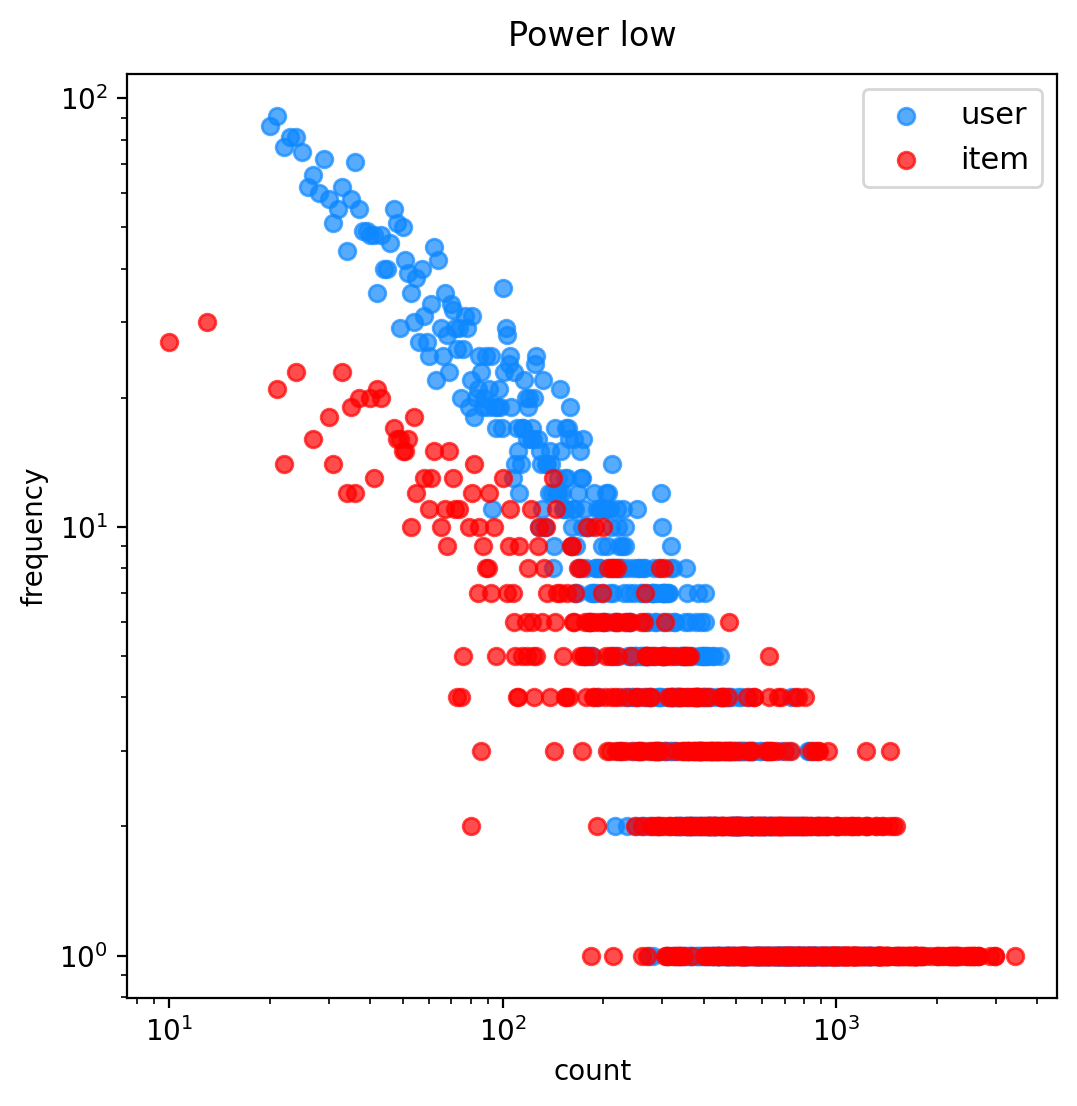

In [427]:
test.plot_freq(save=True)

In [428]:
test.mle_loss(epochs=20, dim=2, with_users_items=False, with_features=False)

Data Training: 100%|██████████| 20/20 [00:46<00:00,  2.32s/it]


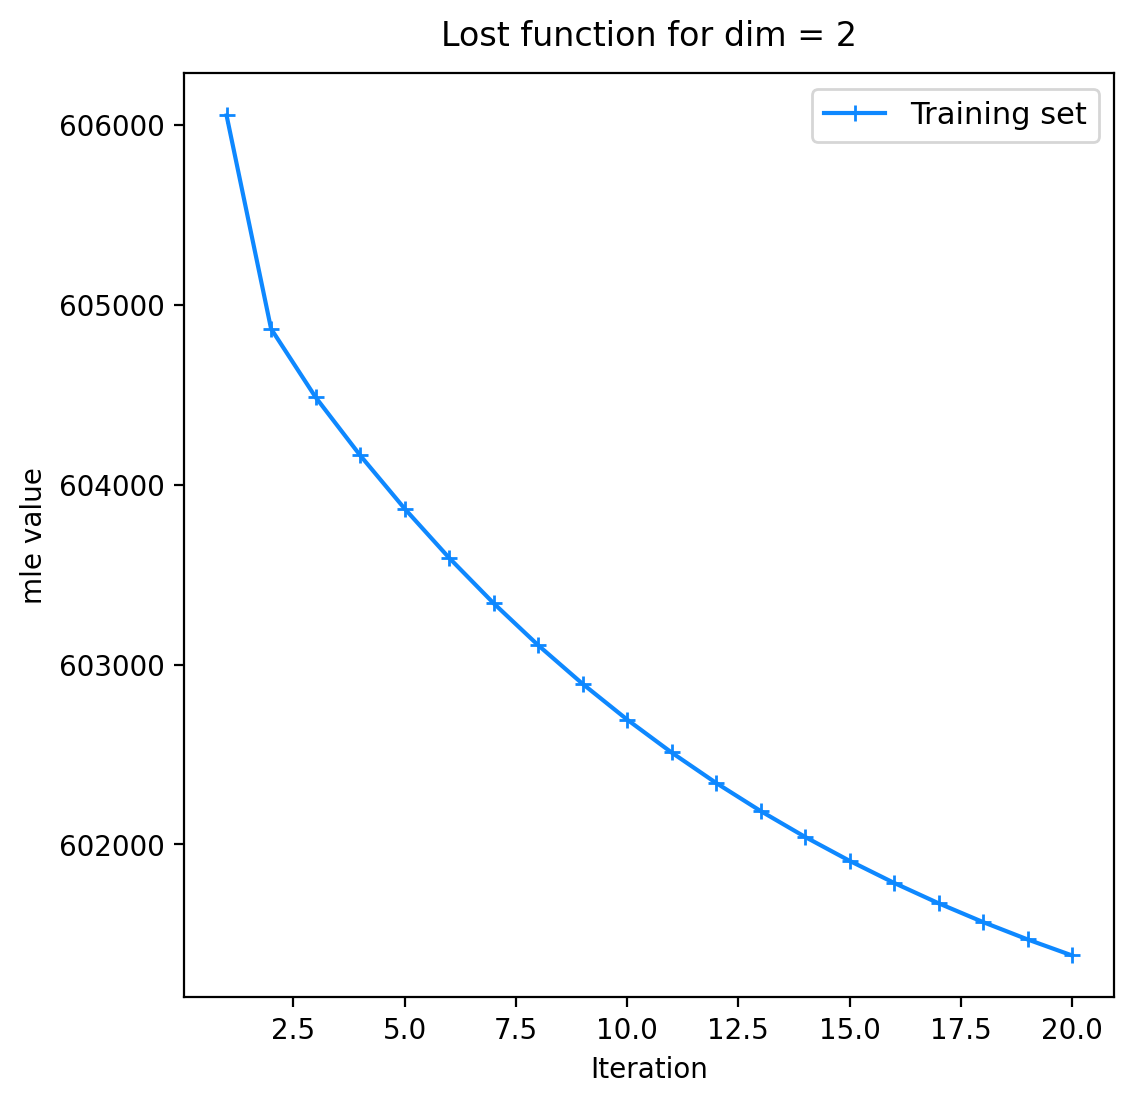

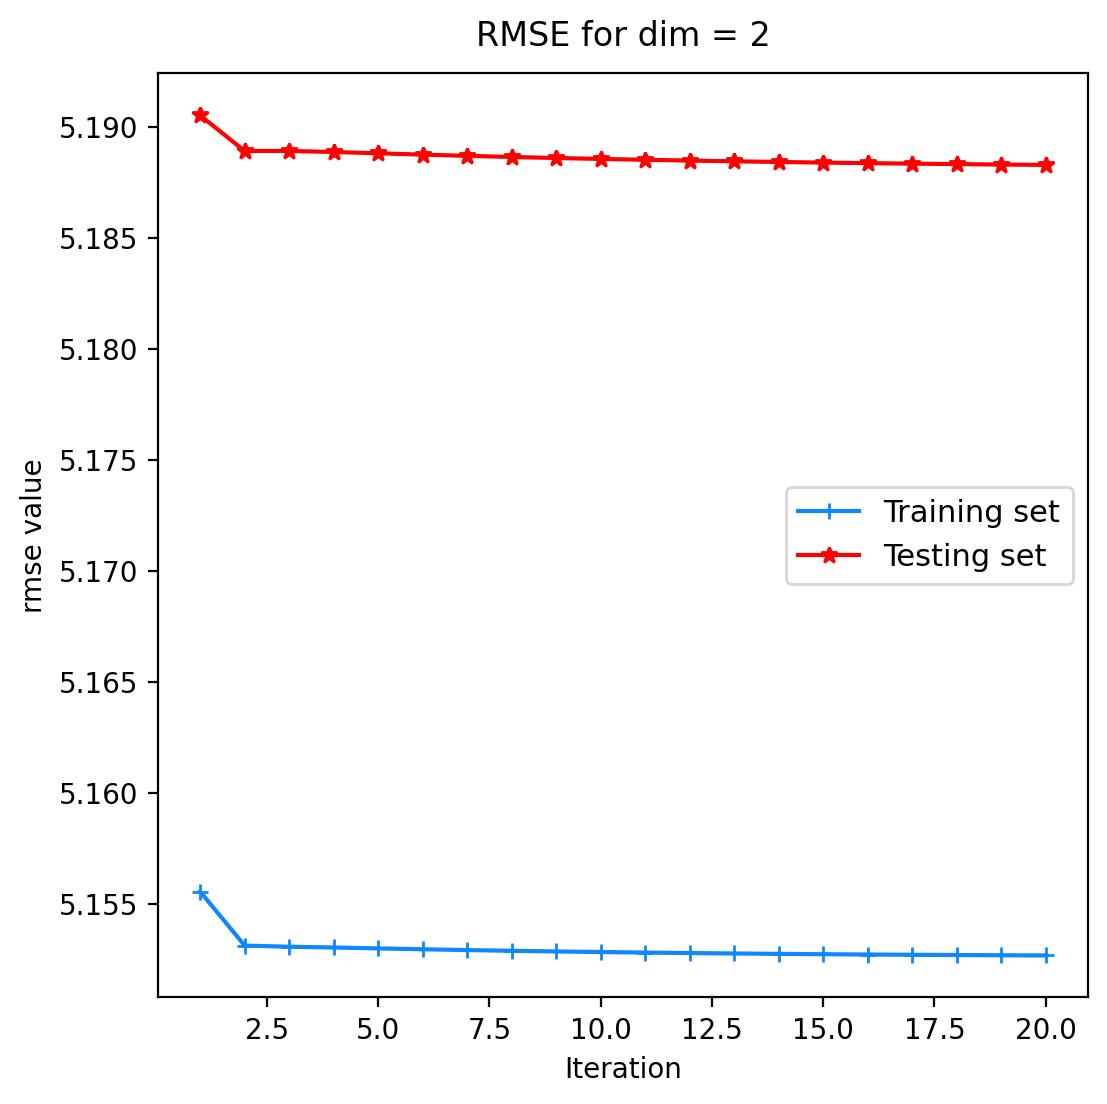

In [429]:
test.plot_loss(save=True)
test.plot_loss(error='rmse', fgname='rmse', title='RMSE', ylabel='rmse value', save=True)

In [430]:
test.mle_loss(epochs=20, dim=2, with_users_items=True, with_features=False)

Data Training: 100%|██████████| 20/20 [02:57<00:00,  8.86s/it]


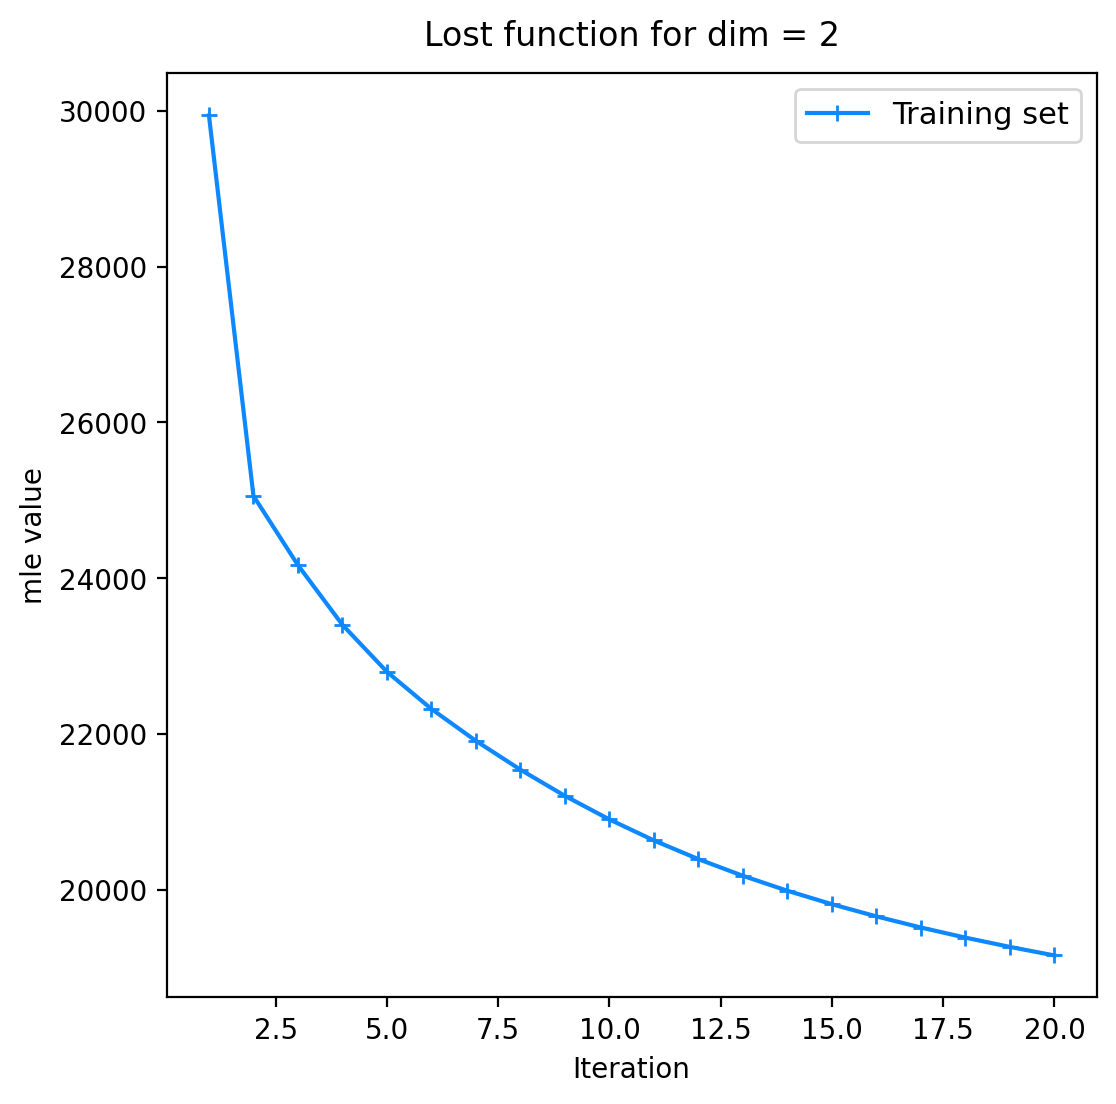

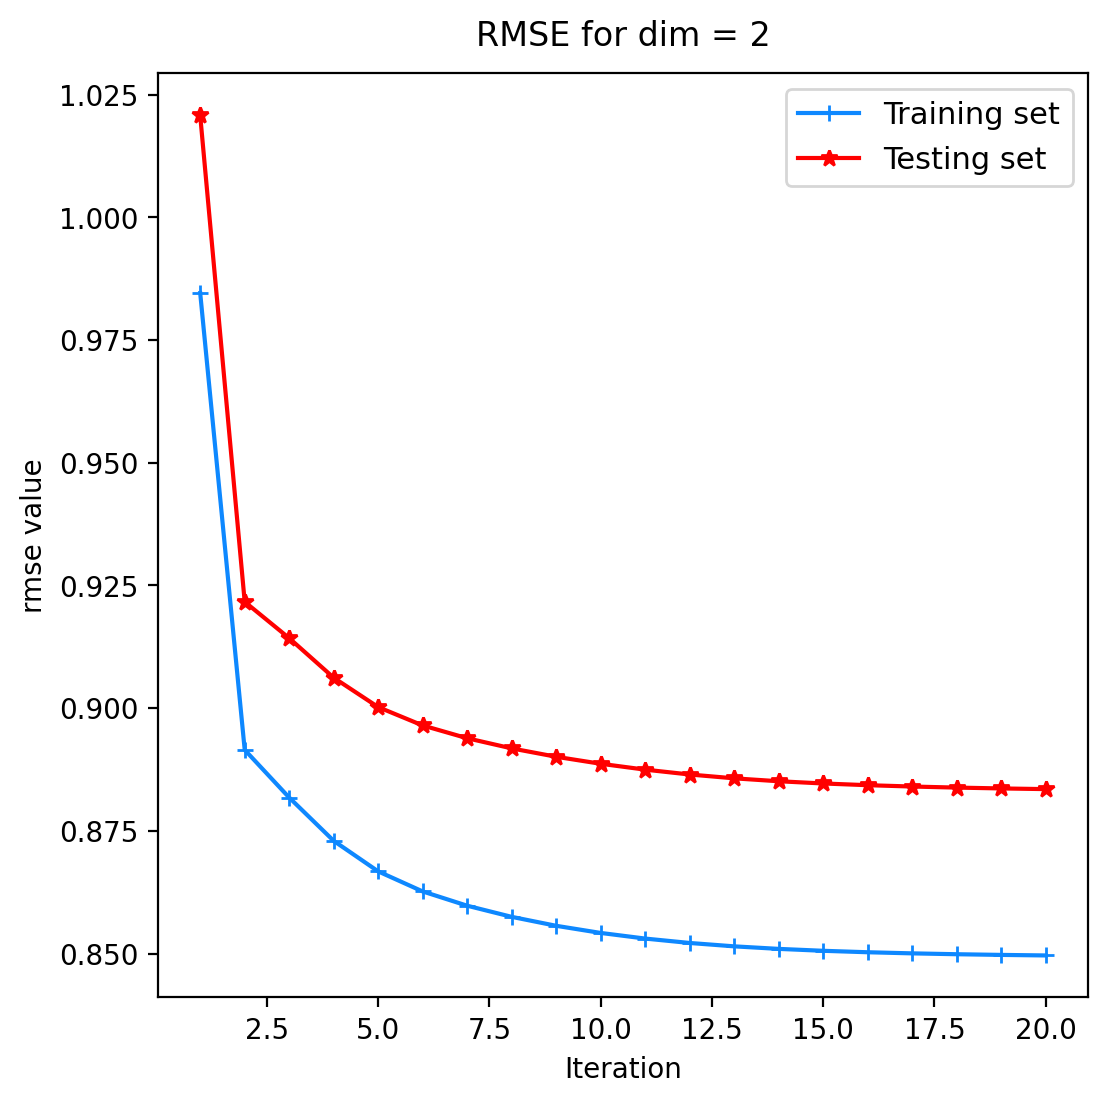

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


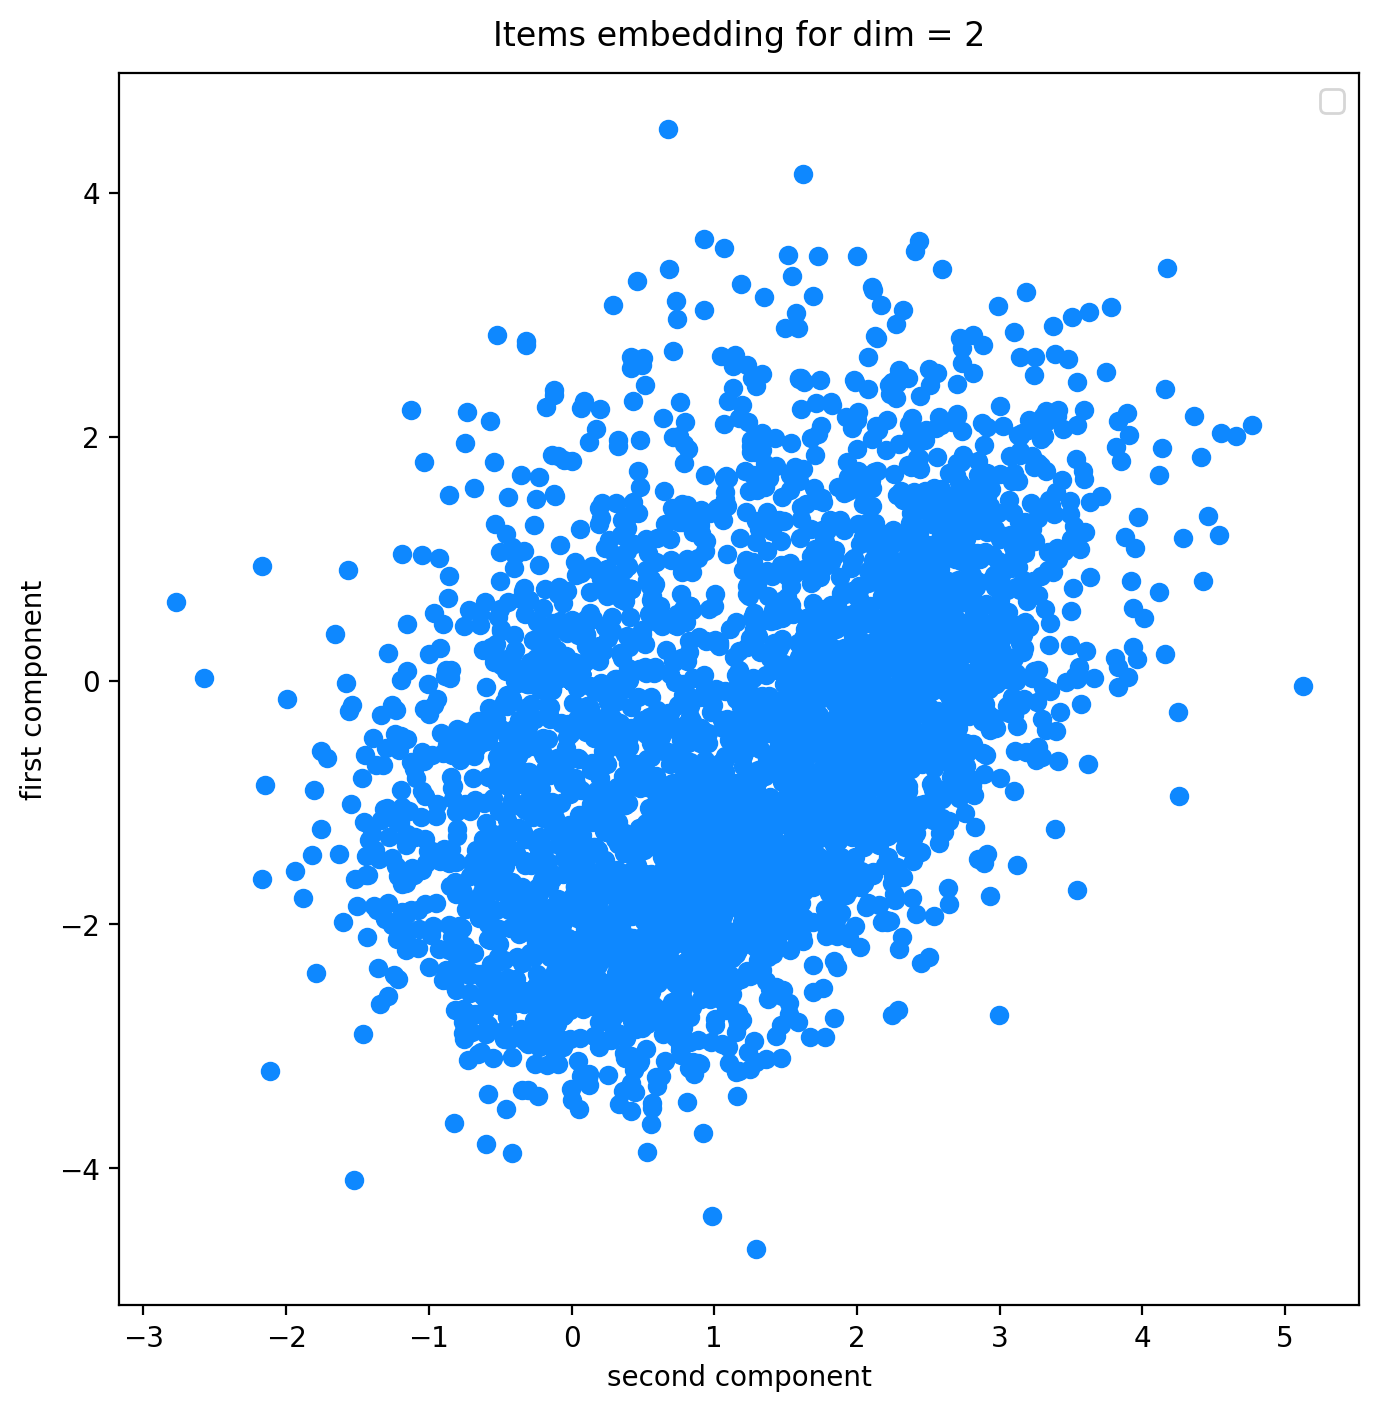

In [431]:
test.plot_loss()
test.plot_loss(error='rmse', fgname='rmse', title='RMSE', ylabel='rmse value')
test.item_embedding()
# test.feature_embedding()

In [432]:
test.mle_loss(epochs=20, dim=2, with_users_items=True, with_features=True)

Data Training: 100%|██████████| 20/20 [02:58<00:00,  8.91s/it]


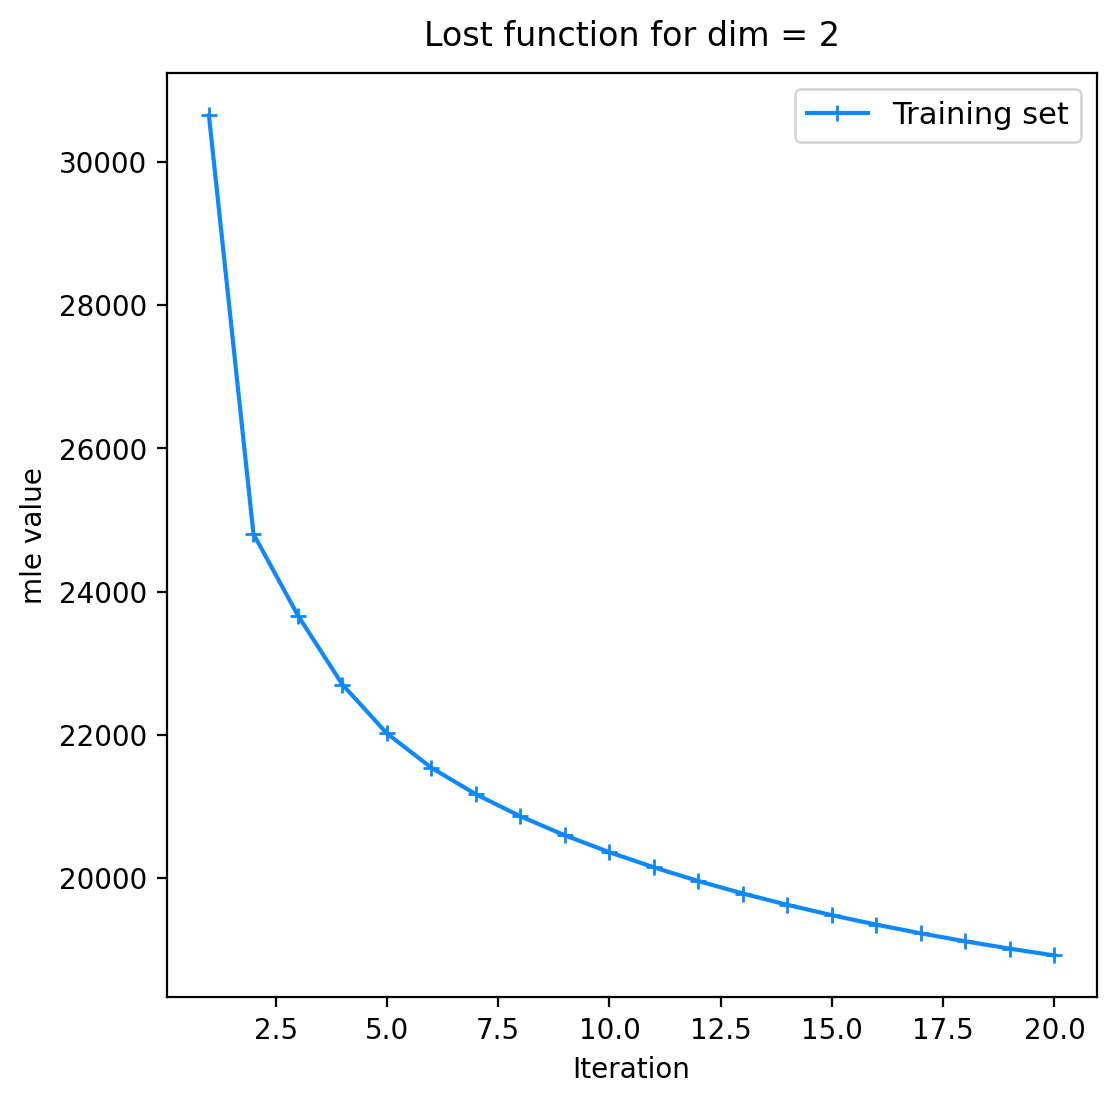

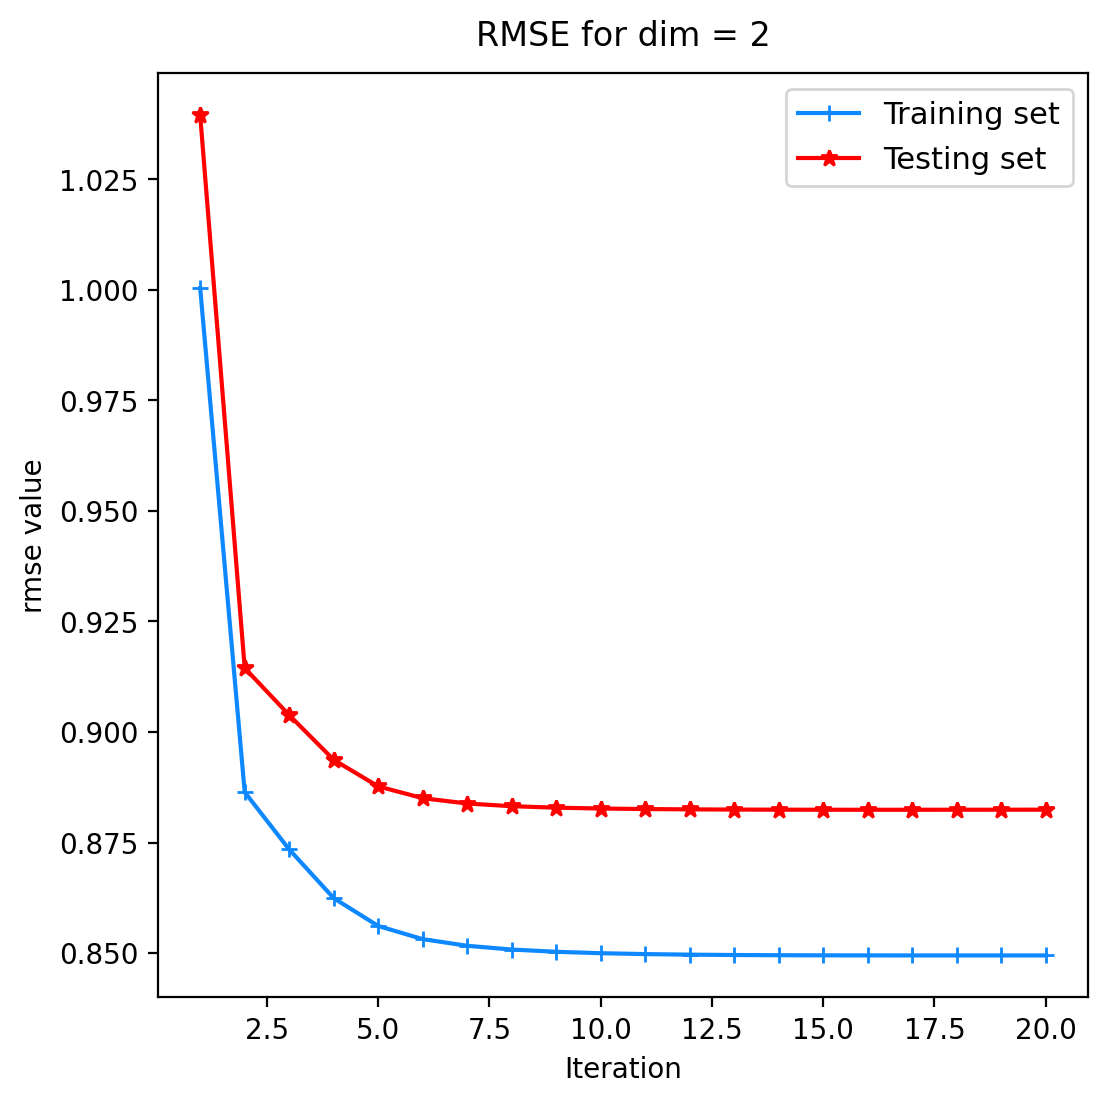

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


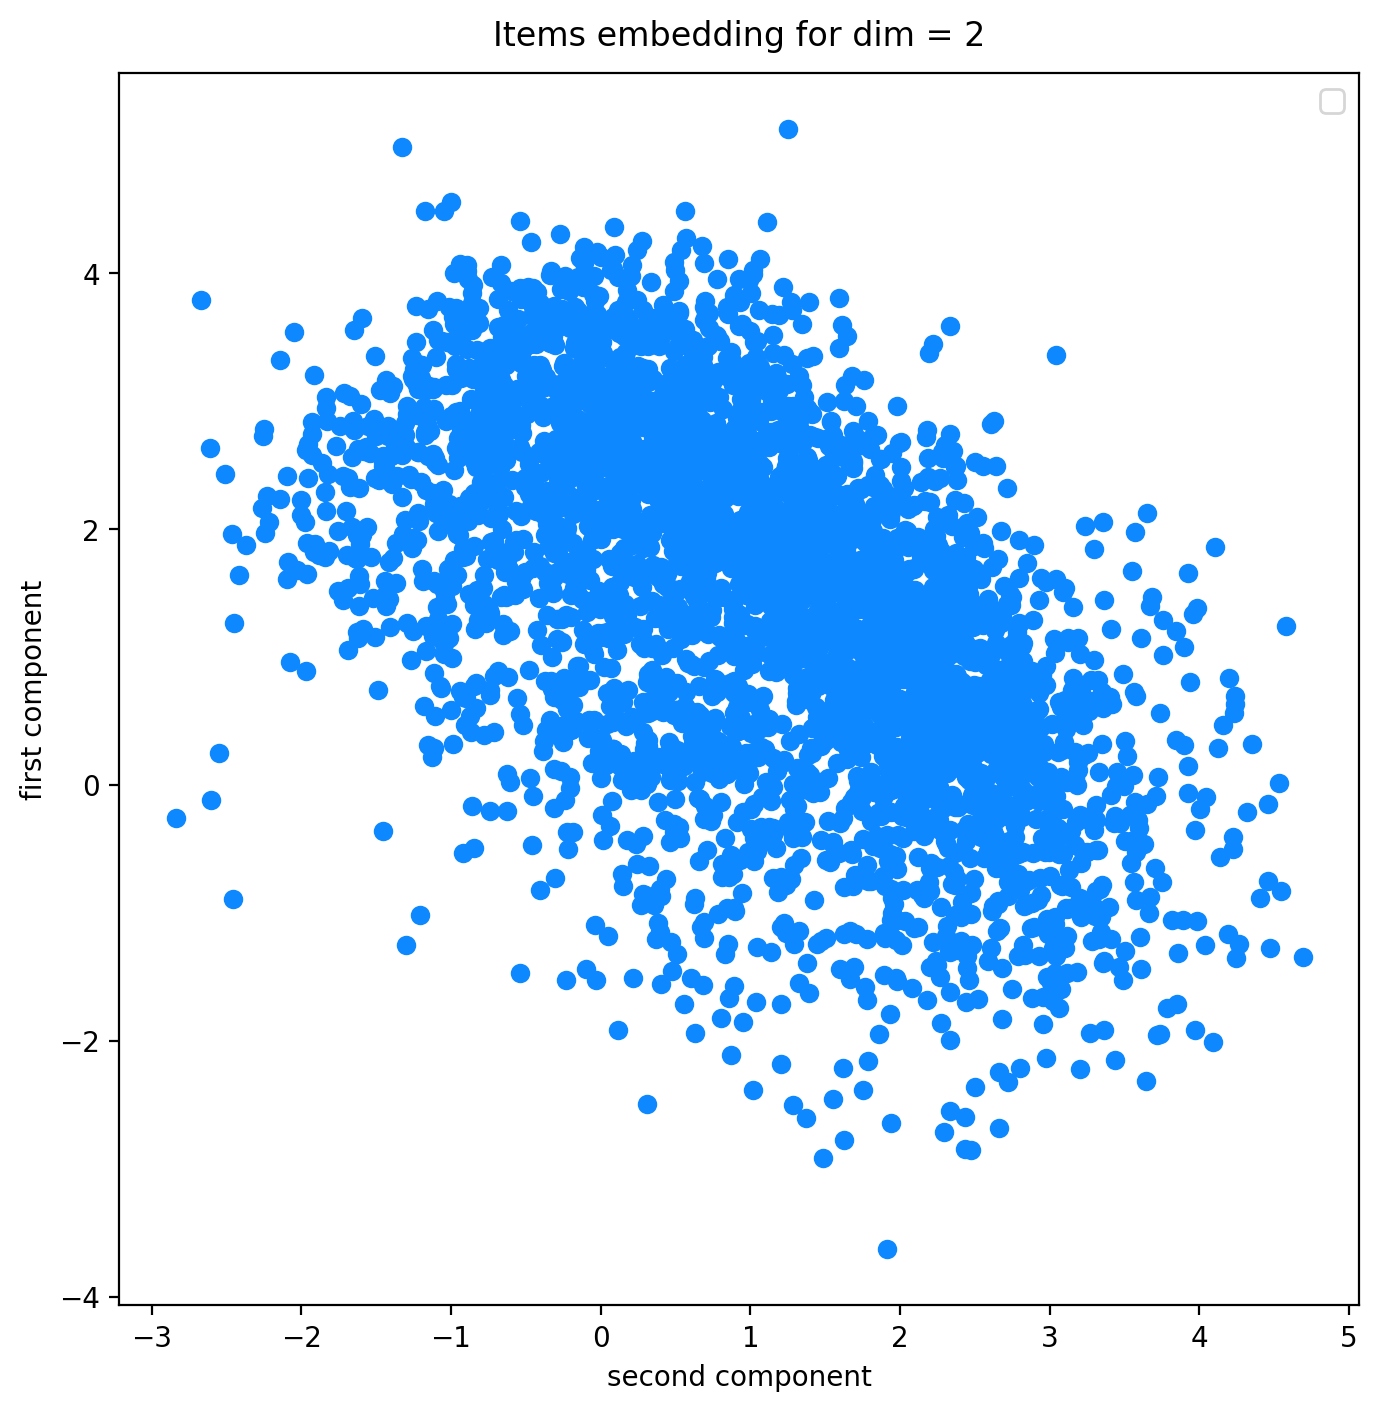

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


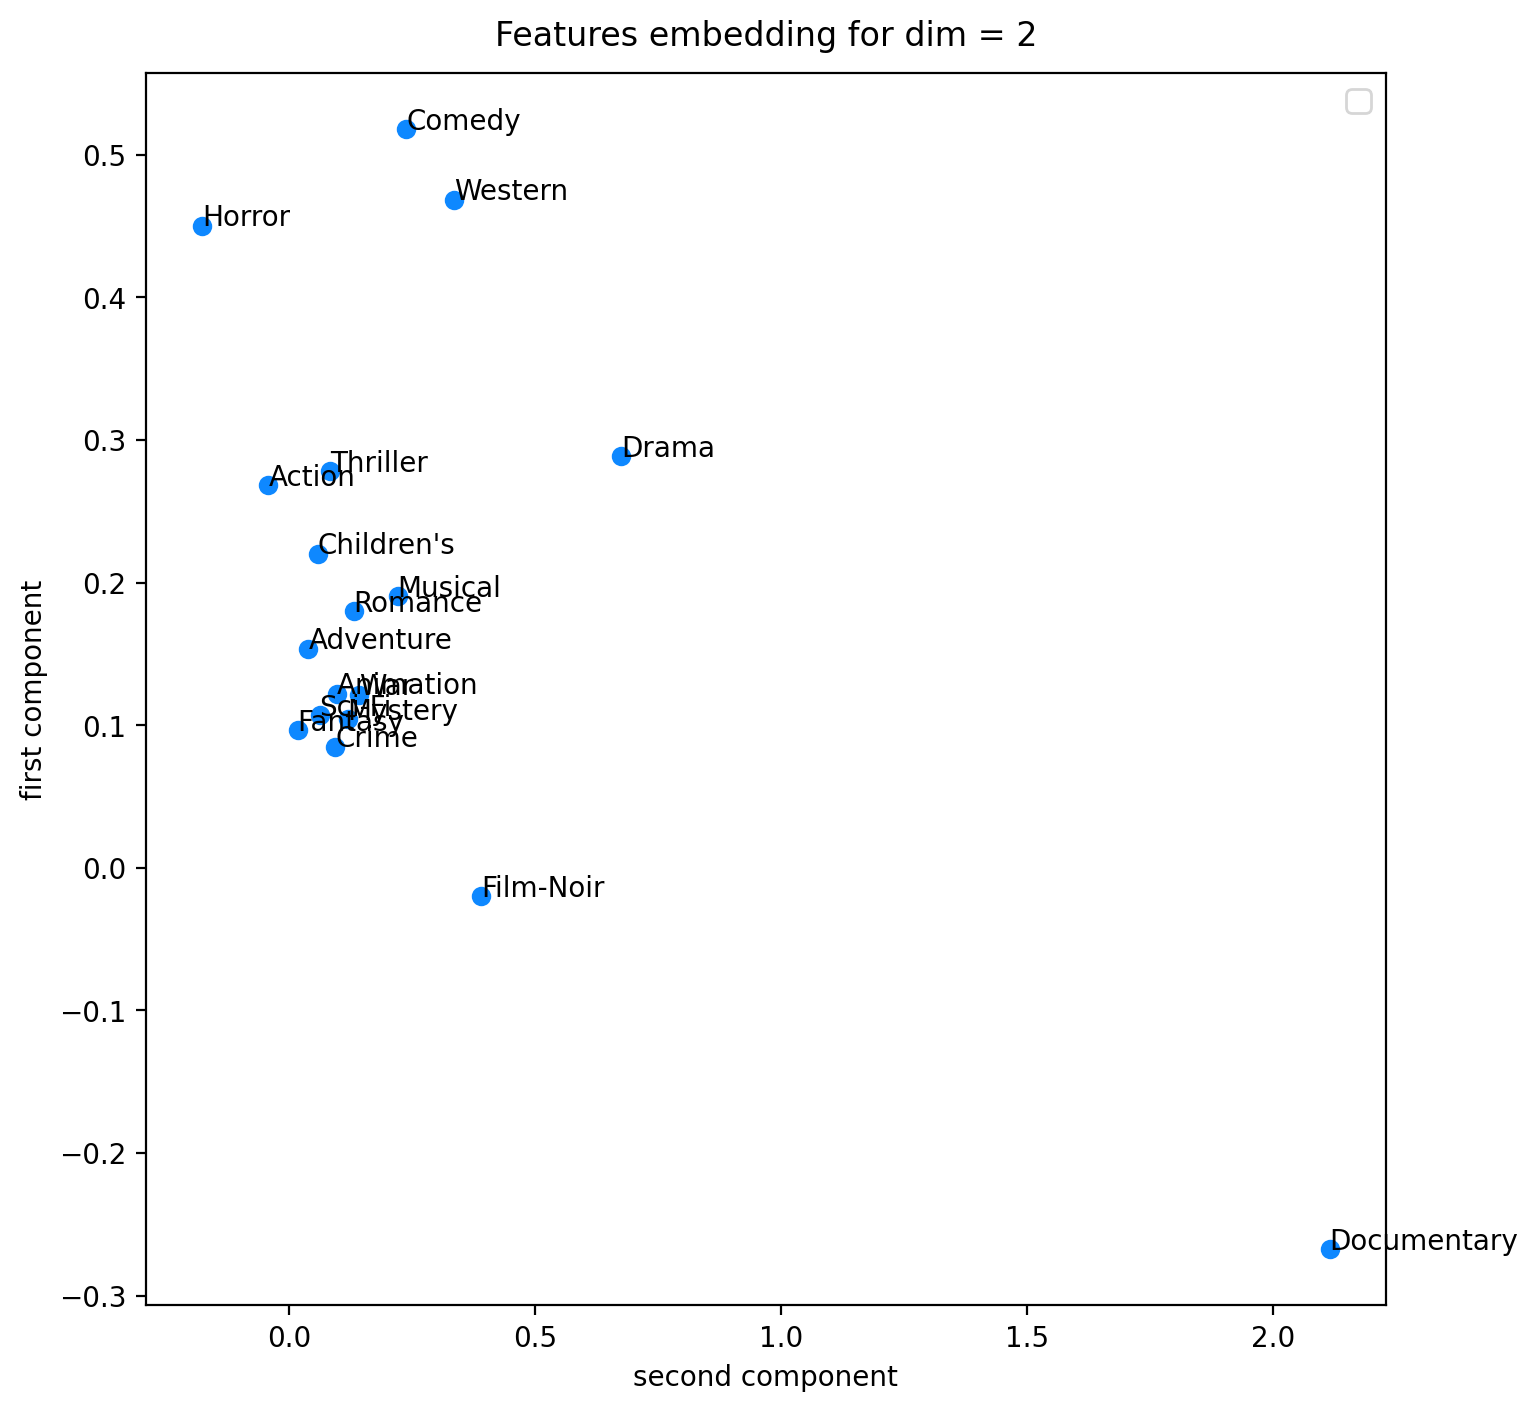

In [433]:
test.plot_loss()
test.plot_loss(error='rmse', fgname='rmse', title='RMSE', ylabel='rmse value')
test.item_embedding()
test.feature_embedding()